In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.decomposition import PCA, KernelPCA
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.inspection import permutation_importance
from sklearn.preprocessing import StandardScaler

from scipy.stats import ks_2samp
from scipy.stats import zscore

import warnings
warnings.filterwarnings('ignore')


In [2]:
dolphin_pewds_biber_df = pd.read_csv("dolphin_pewdipie_biber_features.csv", index_col="doc_id")
phi_pewds_biber_df = pd.read_csv("phi4_pewdiepie_biber_features.csv", index_col="doc_id")
human_pewds_biber_df= pd.read_csv("human_pewdipie_biber_features.csv", index_col="doc_id")

llama_flatearth_biber_df = pd.read_csv("llama3_2_flatearth_biber_features.csv", index_col="doc_id")
phi_flatearth_biber_df = pd.read_csv("phi4_flatearth_biber_features.csv", index_col="doc_id")
human_flatearth_biber_df= pd.read_csv("human_flatearth_biber_features.csv", index_col="doc_id")

deepseek_crypto_biber_df = pd.read_csv("deepseek_CryptoMarkets_biber_features.csv", index_col="doc_id")
phi_crypto_biber_df = pd.read_csv("phi4_CryptoMarkets_biber_features.csv", index_col="doc_id")
human_cypto_biber_df = pd.read_csv("human_CryptoMarkets_biber_features.csv", index_col="doc_id")

# # Optional
llama_cornell_biber_df = pd.read_csv("llama3-2_Cornell_biber_features.csv", index_col="doc_id")
human_cornell_biber_df= pd.read_csv("human_Cornell_biber_features_10k.csv", index_col="doc_id")
dolphin_AITA_biber_df = pd.read_csv("dolphin_AmItheAsshole_biber_features.csv", index_col="doc_id")
human_AITA_biber_df = pd.read_csv("human_AmItheAsshole_biber_features_10k.csv", index_col="doc_id")

# User profile
user_profiles_df = pd.read_csv("user_profiles_biber_features_unaggregated.csv", index_col=["UserID", "subreddit"])

# User profile averages
user_profiles_avg_df = pd.read_csv("user_profiles_biber_features.csv", index_col="doc_id")

# Datasets

### 1. Posts Dataset

In [3]:
# All AI posts combined
ai_df = pd.concat([dolphin_pewds_biber_df,
                   phi_pewds_biber_df,
                   llama_flatearth_biber_df,
                   phi_flatearth_biber_df,
                   deepseek_crypto_biber_df,
                   phi_crypto_biber_df])

ai_df = ai_df.reset_index(drop=True)
ai_df.head()

# All human posts combined
human_df = pd.concat([human_pewds_biber_df,
                      human_flatearth_biber_df,
                      human_cypto_biber_df])

X_posts = pd.concat([ai_df, human_df])
y_posts = np.vstack([
    np.zeros(dtype=np.int32, shape=(ai_df.shape[0], 1)),
    np.ones(dtype=np.int32, shape=(human_df.shape[0], 1))
])

X_posts_train, X_posts_test, y_posts_train, y_posts_test = train_test_split(
    X_posts, y_posts, test_size=0.3, random_state=42, shuffle=True
)


### 2. Profiles Dataset

In [4]:
# Mega dataset with all human profiles
X_posts_large = pd.concat([ai_df, user_profiles_df])
y_posts_large = np.vstack([
    np.zeros(dtype=np.int32, shape=(ai_df.shape[0], 1)),
    np.ones(dtype=np.int32, shape=(user_profiles_df.shape[0], 1))
])

# AI avg Profiles
ai_df['group'] = ai_df.index // 10
ai_profiles_df = ai_df.groupby('group').mean()
ai_profiles_df = ai_profiles_df.reset_index(drop=True)

X_profiles = pd.concat([ai_profiles_df, user_profiles_avg_df])
y_profiles = np.vstack([
    np.zeros(dtype=np.int32, shape=(ai_profiles_df.shape[0], 1)),
    np.ones(dtype=np.int32, shape=(user_profiles_avg_df.shape[0], 1))
])


X_profiles_train, X_profiles_test, y_profiles_train, y_profiles_test = train_test_split(
    X_profiles, y_profiles, test_size=0.3, random_state=42, shuffle=True
)

### 3. Validation set (P1 dataset)

In [5]:
val_ai_df = pd.concat([llama_cornell_biber_df, dolphin_AITA_biber_df])
val_human_df = pd.concat([human_cornell_biber_df, human_AITA_biber_df])

X_val = pd.concat([val_ai_df, val_human_df])
y_val = np.vstack([
    np.zeros(dtype=np.int32, shape=(val_ai_df.shape[0], 1)),
    np.ones(dtype=np.int32, shape=(val_human_df.shape[0], 1))
])

# Post Classification

In [6]:
posts_results = {}
profiles_results = {}
posts_profiles_results = {}

## Random Forests Classifer

### Random forests trained on posts

In [29]:
# Posts classification
rf = RandomForestClassifier(n_estimators=20, random_state=42, max_depth=20)
rf.fit(X_posts_train, y_posts_train)

y_posts_pred = rf.predict(X_posts_test)

# Validation on profiles dataset
y_profiles_pred = rf.predict(X_profiles)

# Validation on P1 dataset
y_val_pred = rf.predict(X_val)

rf_importance = pd.DataFrame({
    'feature': X_posts_train.columns,
    'importance': rf.feature_importances_
}).sort_values('importance', ascending=False)

posts_results["Random Forest"] = {
    "Posts Dataset" : accuracy_score(y_posts_test, y_posts_pred),
    "Profiles Dataset" : accuracy_score(y_profiles, y_profiles_pred),
    "Unseen Dataset" : accuracy_score(y_val, y_val_pred)
}

print(f"{'='*100}")
print(f"Random Forest Trained on Posts Dataset, Test Accuracy score: {accuracy_score(y_posts_test, y_posts_pred)}")
print(f"{'='*100}")
print(f"Random Forest Posts Validated on User and AI profiles, Accuracy score: {accuracy_score(y_profiles, y_profiles_pred)}")
print(classification_report(y_profiles, y_profiles_pred))
print(f"{'='*100}")
print(f"Random Forest Posts Validated on P1 (r/Cornell, r/AITA), Accuracy score: {accuracy_score(y_val, y_val_pred)}")
print(classification_report(y_val, y_val_pred))


/usr/local/lib/python3.12/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Random Forest Trained on Posts Dataset, Test Accuracy score: 0.9730752113929684
Random Forest Posts Validated on User and AI profiles, Accuracy score: 0.28009297692179974
              precision    recall  f1-score   support

           0       0.26      1.00      0.41      3000
           1       1.00      0.04      0.08      9046

    accuracy                           0.28     12046
   macro avg       0.63      0.52      0.24     12046
weighted avg       0.81      0.28      0.16     12046

Random Forest Posts Validated on P1 (r/Cornell, r/AITA), Accuracy score: 0.8803140159616086
              precision    recall  f1-score   support

           0       0.84      0.95      0.89     20000
           1       0.94      0.80      0.86     18342

    accuracy                           0.88     38342
   macro avg       0.89      0.88      0.88     38342
weighted avg       0.89      0.88      0.88     38342



### Random forests trained on profiles

In [30]:
# Profiles classification
rf = RandomForestClassifier(n_estimators=20, random_state=42, max_depth=20)
rf.fit(X_profiles_train, y_profiles_train)

y_profiles_pred = rf.predict(X_profiles_test)

# Validation on posts dataset
y_posts_pred = rf.predict(X_posts)

# Validation on P1 dataset
y_val_pred = rf.predict(X_val)

rf_importance = pd.DataFrame({
    'feature': X_posts_train.columns,
    'importance': rf.feature_importances_
}).sort_values('importance', ascending=False)

profiles_results["Random Forest"] = {
    "Posts Dataset" : accuracy_score(y_posts, y_posts_pred),
    "Profiles Dataset" : accuracy_score(y_profiles_test, y_profiles_pred),
    "Unseen Dataset" : accuracy_score(y_val, y_val_pred)
}


print(f"Random Forest Trained on Profiles Dataset, Test Accuracy score: {accuracy_score(y_profiles_test, y_profiles_pred)}")
print(f"{'='*100}")
print(f"Random Forest Profiles Validated on Posts, Accuracy score: {accuracy_score(y_posts, y_posts_pred)}")
print(f"Classification Report")
print(classification_report(y_posts, y_posts_pred))
print(f"{'='*100}")
print(f"Random Forest Profiles Validated on P1 (r/Cornell, r/AITA), Accuracy score: {accuracy_score(y_val, y_val_pred)}")
print(classification_report(y_val, y_val_pred))

/usr/local/lib/python3.12/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Random Forest Trained on Profiles Dataset, Test Accuracy score: 0.9988931931377975
Random Forest Profiles Validated on Posts, Accuracy score: 0.5881973341640891
Classification Report
              precision    recall  f1-score   support

           0       0.96      0.40      0.57     29999
           1       0.44      0.96      0.61     14940

    accuracy                           0.59     44939
   macro avg       0.70      0.68      0.59     44939
weighted avg       0.79      0.59      0.58     44939

Random Forest Profiles Validated on P1 (r/Cornell, r/AITA), Accuracy score: 0.4851859579573314
              precision    recall  f1-score   support

           0       0.78      0.02      0.04     20000
           1       0.48      0.99      0.65     18342

    accuracy                           0.49     38342
   macro avg       0.63      0.51      0.34     38342
weighted avg       0.64      0.49      0.33     38342



### Random forests trained on posts, tested on profiles using individual posts

In [33]:
# Posts classification but used for profiles
rf = RandomForestClassifier(n_estimators=20, random_state=42, max_depth=20)
rf.fit(X_posts_train, y_posts_train)

# Validation on posts_large dataset
y_posts_large_pred = rf.predict(X_posts_large)

posts_profiles_results["Random Forest"] = {
    "Posts Dataset (Large)" : accuracy_score(y_posts_large, y_posts_large_pred)
}

print(f"{'='*100}")
print(f"Random Forest Trained on Posts Dataset, Validated on Profile's individual posts Accuracy score: {accuracy_score(y_posts_large, y_posts_large_pred)}")
print(classification_report(y_posts_large, y_posts_large_pred))

/usr/local/lib/python3.12/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Random Forest Trained on Posts Dataset, Validated on Profile's individual posts Accuracy score: 0.8416600879666178
              precision    recall  f1-score   support

           0       0.47      0.99      0.64     29999
           1       1.00      0.82      0.90    182809

    accuracy                           0.84    212808
   macro avg       0.73      0.90      0.77    212808
weighted avg       0.92      0.84      0.86    212808



## Logistic Regression Classifier

### Logistic Regression Classifier on posts

In [40]:
lr = LogisticRegression(max_iter=1000, random_state=42)

scaler = StandardScaler()
X_posts_train_scaled = scaler.fit_transform(X_posts_train)

lr.fit(X_posts_train_scaled, y_posts_train)

X_posts_test_scaled = scaler.transform(X_posts_test)
y_posts_pred = lr.predict(X_posts_test_scaled)

# Validation on profiles dataset
X_profiles_scaled = scaler.transform(X_profiles)
y_profiles_pred = lr.predict(X_profiles_scaled)

# Validation on P1 dataset
y_val_pred = lr.predict(X_val)

posts_results["Logistic Regression"] = {
    "Posts Dataset" : accuracy_score(y_posts_test, y_posts_pred),
    "Profiles Dataset" : accuracy_score(y_profiles, y_profiles_pred),
    "Unseen Dataset" : accuracy_score(y_val, y_val_pred)
}

print(f"Logistic Regression Classifier Trained on Posts Dataset, Test Accuracy score: {accuracy_score(y_posts_test, y_posts_pred)}")
print(f"{'='*100}")
print(f"Logistic Regression Classifier Posts Validated on User and AI profiles, Accuracy score: {accuracy_score(y_profiles, y_profiles_pred)}")
print(classification_report(y_profiles, y_profiles_pred))
print(f"{'='*100}")
print(f"Logistic Regression Classifier Posts Validated on P1 (r/Cornell, r/AITA), Accuracy score: {accuracy_score(y_val, y_val_pred)}")
print(classification_report(y_val, y_val_pred))

Logistic Regression Classifier Trained on Posts Dataset, Test Accuracy score: 0.9179646936656283
Logistic Regression Classifier Posts Validated on User and AI profiles, Accuracy score: 0.26075045658309814
              precision    recall  f1-score   support

           0       0.25      1.00      0.40      3000
           1       0.99      0.02      0.03      9046

    accuracy                           0.26     12046
   macro avg       0.62      0.51      0.22     12046
weighted avg       0.80      0.26      0.12     12046

Logistic Regression Classifier Posts Validated on P1 (r/Cornell, r/AITA), Accuracy score: 0.396614678420531
              precision    recall  f1-score   support

           0       0.01      0.00      0.00     20000
           1       0.43      0.83      0.57     18342

    accuracy                           0.40     38342
   macro avg       0.22      0.41      0.29     38342
weighted avg       0.21      0.40      0.27     38342



### Logistic Regression Classifier on profiles

In [41]:
lr = LogisticRegression(max_iter=1000, random_state=42)

scaler = StandardScaler()
X_profiles_train_scaled = scaler.fit_transform(X_profiles_train)

lr.fit(X_profiles_train_scaled, y_profiles_train)

X_profiles_test_scaled = scaler.transform(X_profiles_test)
y_profiles_test_pred = lr.predict(X_profiles_test_scaled)

# Validation on posts dataset
X_posts_scaled = scaler.transform(X_posts)
y_posts_pred = lr.predict(X_posts_scaled)

# Validation on P1 dataset
y_val_pred = lr.predict(X_val)

profiles_results["Logistic Regression"] = {
    "Posts Dataset" : accuracy_score(y_posts, y_posts_pred),
    "Profiles Dataset" : accuracy_score(y_profiles_test, y_profiles_test_pred),
    "Unseen Dataset" : accuracy_score(y_val, y_val_pred),
}

print(f"Logistic Regression Classifier Trained on Profiles Dataset, Test Accuracy score: {accuracy_score(y_profiles_test, y_profiles_test_pred)}")
print(f"{'='*100}")
print(f"Logistic Regression Classifier Validated on Posts, Accuracy score: {accuracy_score(y_posts, y_posts_pred)}")
print(classification_report(y_posts, y_posts_pred))
print(f"{'='*100}")
print(f"Logistic Regression Classifier Validated on P1 (r/Cornell, r/AITA), Accuracy score: {accuracy_score(y_val, y_val_pred)}")
print(classification_report(y_val, y_val_pred))


Logistic Regression Classifier Trained on Profiles Dataset, Test Accuracy score: 0.996956281128943
Logistic Regression Classifier Validated on Posts, Accuracy score: 0.8135027481697412
              precision    recall  f1-score   support

           0       0.84      0.89      0.86     29999
           1       0.75      0.66      0.70     14940

    accuracy                           0.81     44939
   macro avg       0.79      0.77      0.78     44939
weighted avg       0.81      0.81      0.81     44939

Logistic Regression Classifier Validated on P1 (r/Cornell, r/AITA), Accuracy score: 0.430285326795681
              precision    recall  f1-score   support

           0       0.00      0.00      0.00     20000
           1       0.45      0.90      0.60     18342

    accuracy                           0.43     38342
   macro avg       0.23      0.45      0.30     38342
weighted avg       0.22      0.43      0.29     38342



### Logistic Regression classifier trained on posts, tested on profiles using individual posts

In [42]:
lr = LogisticRegression(max_iter=1000, random_state=42)

scaler = StandardScaler()
X_posts_train_scaled = scaler.fit_transform(X_posts_train)

lr.fit(X_posts_train_scaled, y_posts_train)

# Validation on posts_large dataset
X_posts_large_scaled = scaler.transform(X_posts_large)

nan_mask = np.isnan(X_posts_large_scaled)
clean_rows = ~(nan_mask.any(axis=1))
X_posts_large_scaled = X_posts_large_scaled[clean_rows]
y_posts_large_clean = y_posts_large[clean_rows]

y_posts_large_pred = lr.predict(X_posts_large_scaled)

posts_profiles_results["Logistic Regression"] = {
    "Posts Dataset (Large)" : accuracy_score(y_posts_large_clean, y_posts_large_pred),
}

print(f"Random Forest Trained on Posts Dataset, Validated on Profile's individual posts Accuracy score: {accuracy_score(y_posts_large_clean, y_posts_large_pred)}")
print(classification_report(y_posts_large_clean, y_posts_large_pred))

Random Forest Trained on Posts Dataset, Validated on Profile's individual posts Accuracy score: 0.6408998185698036
              precision    recall  f1-score   support

           0       0.28      0.96      0.43     29999
           1       0.99      0.59      0.74    182755

    accuracy                           0.64    212754
   macro avg       0.63      0.77      0.58    212754
weighted avg       0.89      0.64      0.69    212754



## Gradient Boosting Classifier

### Gradient Boosting Classifier on posts

In [51]:
# Posts classification
gb = GradientBoostingClassifier(n_estimators=70, random_state=42, max_depth=7)
gb.fit(X_posts_train, y_posts_train)

y_posts_pred = gb.predict(X_posts_test)

# Validation on profiles dataset
y_profiles_pred = gb.predict(X_profiles)

# Validation on P1 dataset
y_val_pred = gb.predict(X_val)

posts_results["Gradient Boosting"] = {
    "Posts Dataset" : accuracy_score(y_posts_test, y_posts_pred),
    "Profiles Dataset" : accuracy_score(y_profiles, y_profiles_pred),
    "Unseen Dataset" : accuracy_score(y_val, y_val_pred)
}

print(f"Gradient Boosting Classifier Trained on Posts Dataset, Test Accuracy score: {accuracy_score(y_posts_test, y_posts_pred)}")
print(f"{'='*100}")
print(f"Gradient Boosting Posts Classifier Validated on User and AI profiles, Accuracy score: {accuracy_score(y_profiles, y_profiles_pred)}")
print(classification_report(y_profiles, y_profiles_pred))
print(f"{'='*100}")
print(f"Gradient Boosting Posts Classifier Validated on P1 (r/Cornell, r/AITA), Accuracy score: {accuracy_score(y_val, y_val_pred)}")
print(classification_report(y_val, y_val_pred))

Gradient Boosting Classifier Trained on Posts Dataset, Test Accuracy score: 0.9751520545913069
Gradient Boosting Posts Classifier Validated on User and AI profiles, Accuracy score: 0.31221982400796944
              precision    recall  f1-score   support

           0       0.27      1.00      0.42      3000
           1       1.00      0.08      0.16      9046

    accuracy                           0.31     12046
   macro avg       0.63      0.54      0.29     12046
weighted avg       0.82      0.31      0.22     12046

Gradient Boosting Posts Classifier Validated on P1 (r/Cornell, r/AITA), Accuracy score: 0.8795576652235146
              precision    recall  f1-score   support

           0       0.86      0.92      0.89     20000
           1       0.91      0.83      0.87     18342

    accuracy                           0.88     38342
   macro avg       0.88      0.88      0.88     38342
weighted avg       0.88      0.88      0.88     38342



### Gradient Boosting Classifier on profiles

In [52]:
# Profiles classification
gb = GradientBoostingClassifier(n_estimators=70, random_state=42, max_depth=7)
gb.fit(X_profiles_train, y_profiles_train)

y_profiles_pred = gb.predict(X_profiles_test)

# Validation on posts dataset
y_posts_pred = gb.predict(X_posts)

# Validation on P1 dataset
y_val_pred = gb.predict(X_val)

profiles_results["Gradient Boosting"] = {
    "Posts Dataset" : accuracy_score(y_posts, y_posts_pred),
    "Profiles Dataset" : accuracy_score(y_profiles_test, y_profiles_pred),
    "Unseen Dataset" : accuracy_score(y_val, y_val_pred),
}

print(f"Gradient Boosting Classifier Trained on Profiles Dataset, Test Accuracy score: {accuracy_score(y_profiles_test, y_profiles_pred)}")
print(f"{'='*100}")
print(f"Gradient Boosting Profiles Classifier Validated on Posts, Accuracy score: {accuracy_score(y_posts, y_posts_pred)}")
print(classification_report(y_posts, y_posts_pred))
print(f"{'='*100}")
print(f"Gradient Boosting Profiles Classifier Validated on P1 (r/Cornell, r/AITA), Accuracy score: {accuracy_score(y_val, y_val_pred)}")
print(classification_report(y_val, y_val_pred))

Gradient Boosting Classifier Trained on Profiles Dataset, Test Accuracy score: 0.9975096845600443
Gradient Boosting Profiles Classifier Validated on Posts, Accuracy score: 0.520194040810877
              precision    recall  f1-score   support

           0       0.93      0.30      0.46     29999
           1       0.41      0.95      0.57     14940

    accuracy                           0.52     44939
   macro avg       0.67      0.63      0.51     44939
weighted avg       0.75      0.52      0.50     44939

Gradient Boosting Profiles Classifier Validated on P1 (r/Cornell, r/AITA), Accuracy score: 0.49460122059360495
              precision    recall  f1-score   support

           0       0.74      0.05      0.09     20000
           1       0.49      0.98      0.65     18342

    accuracy                           0.49     38342
   macro avg       0.61      0.51      0.37     38342
weighted avg       0.62      0.49      0.36     38342



### Gradient Boosting Classifier trained on posts, tested on profiles using individual posts

In [53]:
# Posts classification but used for profiles
gb = GradientBoostingClassifier(n_estimators=70, random_state=42, max_depth=7)
gb.fit(X_posts_train, y_posts_train)

# Validation on posts_large dataset
nan_mask = np.isnan(X_posts_large)
clean_rows = ~(nan_mask.any(axis=1))
X_posts_large_clean = X_posts_large[clean_rows]
y_posts_large_clean = y_posts_large[clean_rows]

y_posts_large_pred = gb.predict(X_posts_large_clean)

posts_profiles_results["Gradient Boosting"] = {
    "Posts Dataset (Large)" : accuracy_score(y_posts_large_clean, y_posts_large_pred),
}

print(f"Gradient Boosting Posts Classifier, Validated on Profile's individual posts Accuracy score: {accuracy_score(y_posts_large_clean, y_posts_large_pred)}")
print(classification_report(y_posts_large_clean, y_posts_large_pred))

Gradient Boosting Posts Classifier, Validated on Profile's individual posts Accuracy score: 0.8540944001052859
              precision    recall  f1-score   support

           0       0.49      0.99      0.66     29999
           1       1.00      0.83      0.91    182755

    accuracy                           0.85    212754
   macro avg       0.74      0.91      0.78    212754
weighted avg       0.93      0.85      0.87    212754



# Plotting the classification results

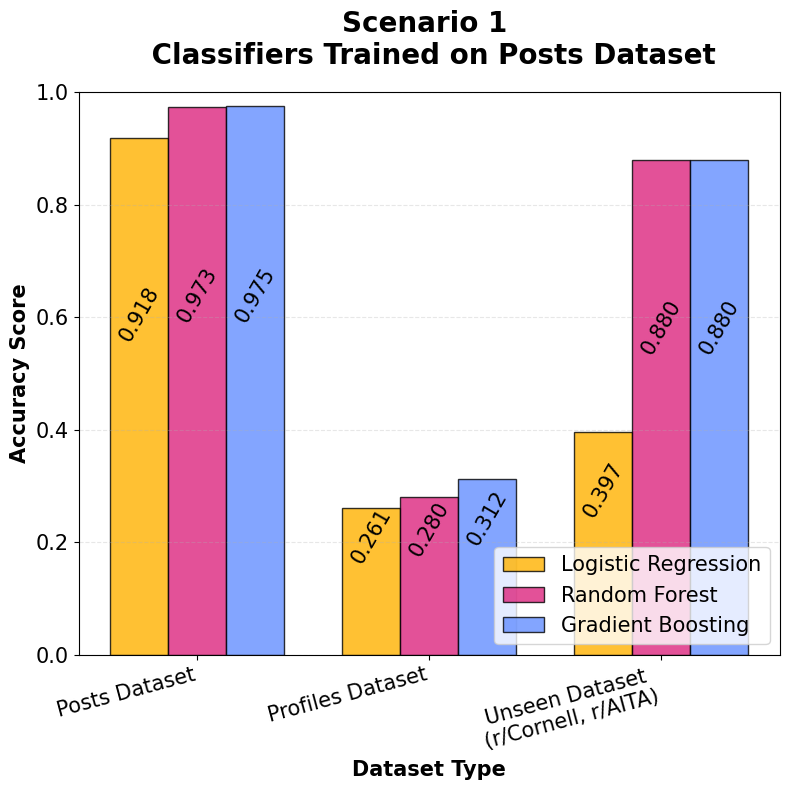

In [74]:
import matplotlib.pyplot as plt
import numpy as np

# Colors for each classifier
colors = ['#FFB200', '#DC267F', '#648FFF']
classifiers = ['Logistic Regression', 'Random Forest', 'Gradient Boosting']

# ===== PLOT 1: Trained on Posts Dataset =====
plt.figure(figsize=(8, 8))
test_types = list(posts_results['Logistic Regression'].keys())
for i in range(len(test_types)):
    if test_types[i] == "Unseen Dataset":
        test_types[i] = "Unseen Dataset \n (r/Cornell, r/AITA)"
        break

x = np.arange(len(test_types))
width = 0.25

for idx, classifier in enumerate(classifiers):
    values = list(posts_results[classifier].values())
    offset = (idx - 1) * width
    bars = plt.bar(x + offset, values, width, label=classifier, color=colors[idx], alpha=0.8, edgecolor="black", linewidth=1.0)

    # Add value labels on bars
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height * 0.6,
                f'{height:.3f}',
                ha='center', va='bottom', fontsize=15, rotation=60)

plt.xlabel('Dataset Type', fontweight='bold', fontsize=15)
plt.ylabel('Accuracy Score', fontweight='bold', fontsize=15)
plt.title('Scenario 1 \n Classifiers Trained on Posts Dataset', fontweight='bold', fontsize=20, pad=20)
plt.xticks(x, test_types, rotation=15, ha='right', fontsize=15)
plt.yticks(fontsize=15)
plt.legend(loc='lower right', fontsize=15)
plt.ylim(0, 1.0)
plt.grid(axis='y', alpha=0.3, linestyle='--')
plt.tight_layout()
plt.show()

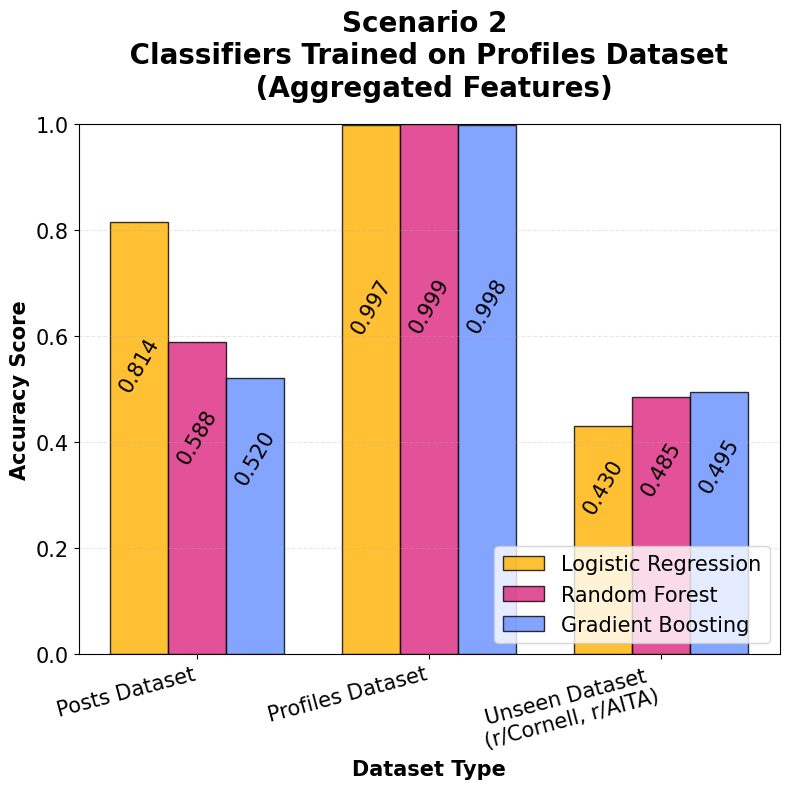

In [75]:
import matplotlib.pyplot as plt
import numpy as np

# Colors for each classifier
colors = ['#FFB200', '#DC267F', '#648FFF']
classifiers = ['Logistic Regression', 'Random Forest', 'Gradient Boosting']

# ===== PLOT 1: Trained on Posts Dataset =====
plt.figure(figsize=(8, 8))
test_types = list(profiles_results['Logistic Regression'].keys())
for i in range(len(test_types)):
    if test_types[i] == "Unseen Dataset":
        test_types[i] = "Unseen Dataset \n (r/Cornell, r/AITA)"
        break

x = np.arange(len(test_types))
width = 0.25

for idx, classifier in enumerate(classifiers):
    values = list(profiles_results[classifier].values())
    offset = (idx - 1) * width
    bars = plt.bar(x + offset, values, width, label=classifier, color=colors[idx], alpha=0.8, edgecolor="black", linewidth=1.0)

    # Add value labels on bars
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height * 0.6,
                f'{height:.3f}',
                ha='center', va='bottom', fontsize=15, rotation=60)

plt.xlabel('Dataset Type', fontweight='bold', fontsize=15)
plt.ylabel('Accuracy Score', fontweight='bold', fontsize=15)
plt.title('Scenario 2 \n Classifiers Trained on Profiles Dataset \n (Aggregated Features)', fontweight='bold', fontsize=20, pad=20)
plt.xticks(x, test_types, rotation=15, ha='right', fontsize=15)
plt.yticks(fontsize=15)
plt.legend(loc='lower right', fontsize=15)
plt.ylim(0, 1.0)
plt.grid(axis='y', alpha=0.3, linestyle='--')
plt.tight_layout()
# plt.savefig('scenario1_posts_trained.png', dpi=300, bbox_inches='tight')
plt.show()

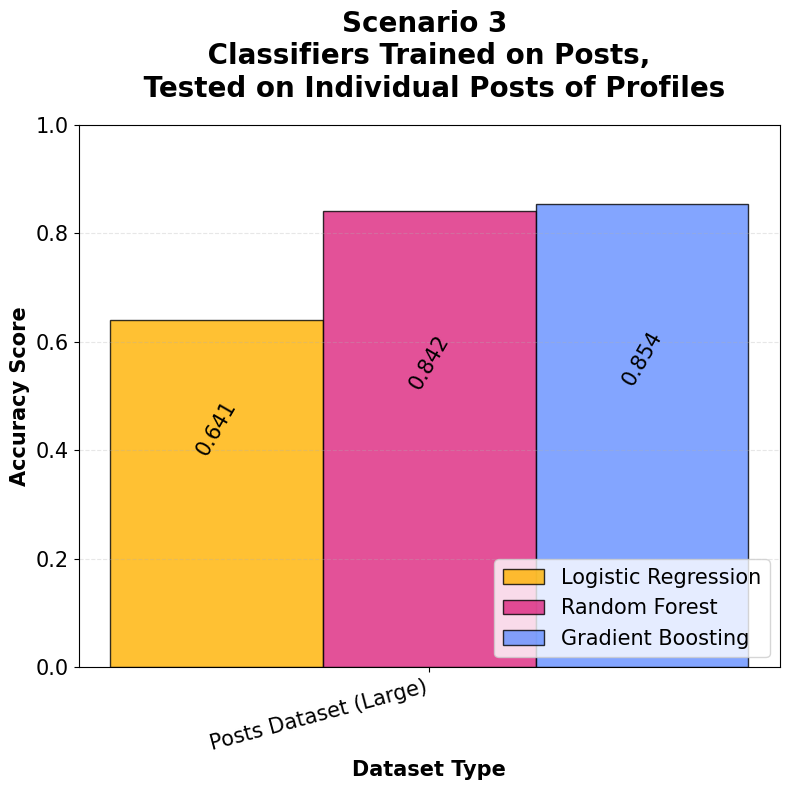

In [76]:
import matplotlib.pyplot as plt
import numpy as np

# Colors for each classifier
colors = ['#FFB200', '#DC267F', '#648FFF']
classifiers = ['Logistic Regression', 'Random Forest', 'Gradient Boosting']

# ===== PLOT 1: Trained on Posts Dataset =====
plt.figure(figsize=(8, 8))
test_types = list(posts_profiles_results['Logistic Regression'].keys())

x = np.arange(len(test_types))
width = 0.25

for idx, classifier in enumerate(classifiers):
    values = list(posts_profiles_results[classifier].values())
    offset = (idx - 1) * width
    bars = plt.bar(x + offset, values, width, label=classifier, color=colors[idx], alpha=0.8, edgecolor="black", linewidth=1.0)

    # Add value labels on bars
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height * 0.6,
                f'{height:.3f}',
                ha='center', va='bottom', fontsize=15, rotation=60)

plt.xlabel('Dataset Type', fontweight='bold', fontsize=15)
plt.ylabel('Accuracy Score', fontweight='bold', fontsize=15)
plt.title('Scenario 3 \n Classifiers Trained on Posts, \n Tested on Individual Posts of Profiles', fontweight='bold', fontsize=20, pad=20)
plt.xticks(x, test_types, rotation=15, ha='right', fontsize=15)
plt.yticks(fontsize=15)
plt.legend(loc='lower right', fontsize=15)
plt.ylim(0, 1.0)
plt.grid(axis='y', alpha=0.3, linestyle='--')
plt.tight_layout()
# plt.savefig('scenario1_posts_trained.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
from sklearn.tree import plot_tree

# Extract and visualize an individual decision tree (e.g., the first one)
plt.figure(figsize=(20, 10))
plot_tree(rf.estimators_[0],
          feature_names=X_posts_large.columns,
          class_names=["AI", "Human"],
          filled=True)
plt.title("Individual Decision Tree from Random Forest")
plt.show()

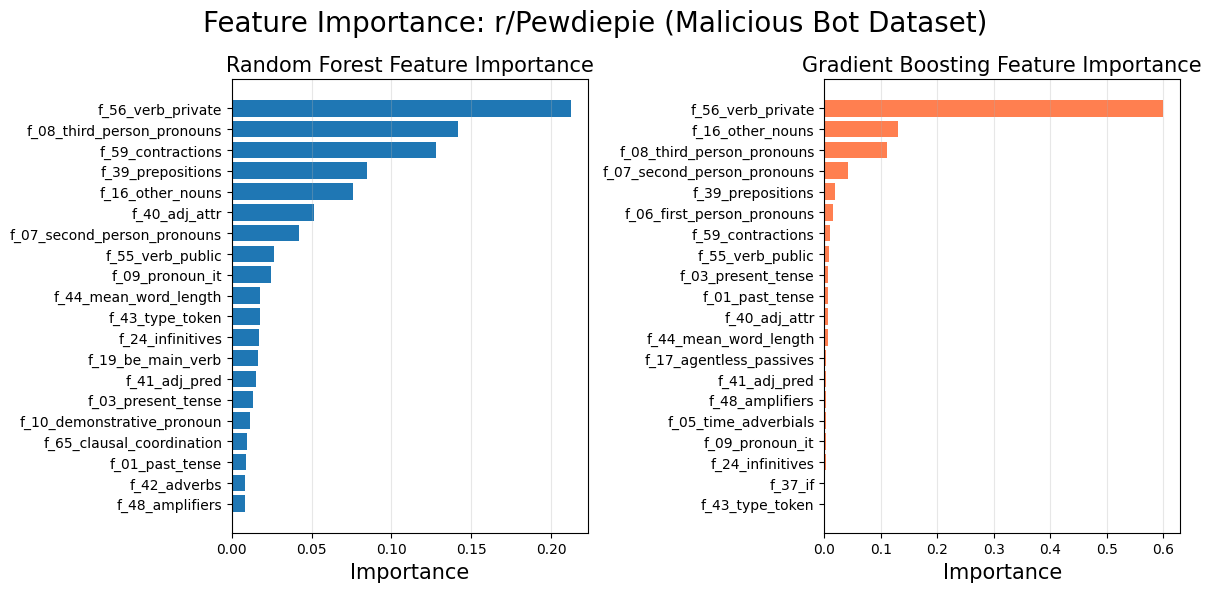

In [ ]:
TOP_N = 5

fig = plt.figure(figsize=(12, 6))
plt.suptitle("Feature Importance: r/Pewdiepie (Malicious Bot Dataset)", fontsize=20)

# Plot 1: Random Forest Importance
ax1 = plt.subplot(1, 2, 1)
top_rf = rf_importance.head(TOP_N)
ax1.barh(range(len(top_rf)), top_rf['importance'])
ax1.set_yticks(range(len(top_rf)))
ax1.set_yticklabels(top_rf['feature'])
ax1.invert_yaxis()
ax1.set_xlabel('Importance', fontsize=15)
ax1.set_title('Random Forest Feature Importance', fontsize=15)
ax1.grid(axis='x', alpha=0.3)

# Plot 2: Gradient Boosting Importance
ax2 = plt.subplot(1, 2, 2)
top_gb = gb_importance.head(TOP_N)
ax2.barh(range(len(top_gb)), top_gb['importance'], color='coral')
ax2.set_yticks(range(len(top_gb)))
ax2.set_yticklabels(top_gb['feature'])
ax2.invert_yaxis()
ax2.set_xlabel('Importance', fontsize=15)
ax2.set_title('Gradient Boosting Feature Importance', fontsize=15)
ax2.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

# KS test significant features

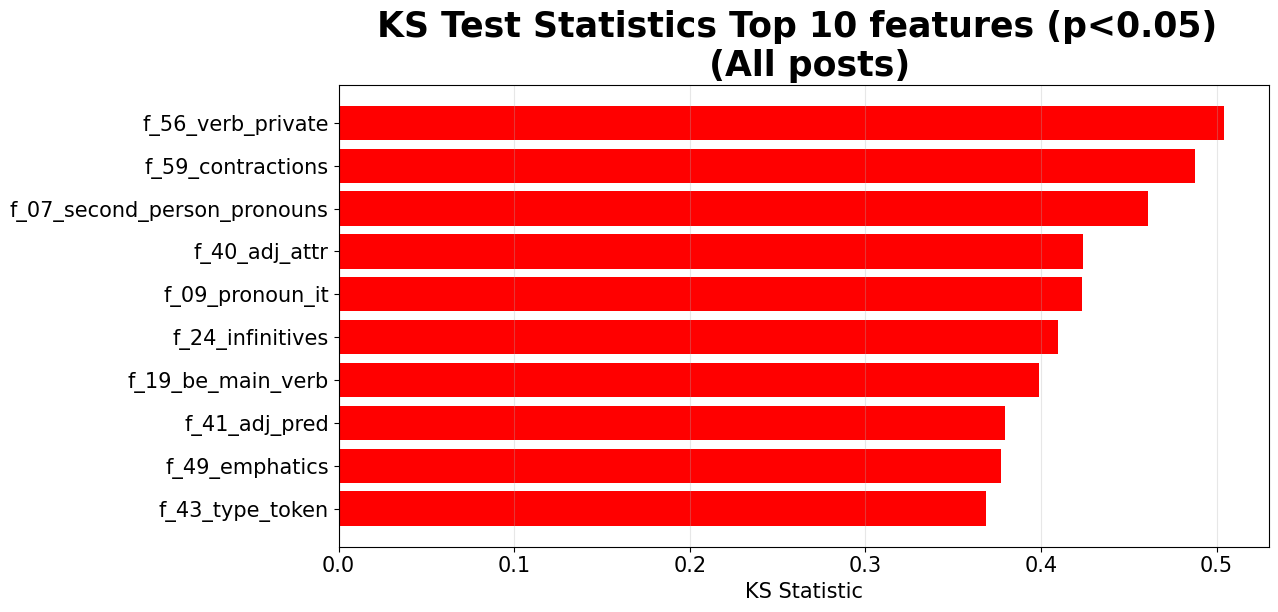

In [ ]:
TOP_N = 10

ks_results = []
for col in X_posts_large.columns:
    class_0 = X_posts_large[y_posts_large == 0][col].dropna()
    class_1 = X_posts_large[y_posts_large == 1][col].dropna()
    stat, p_val = ks_2samp(class_0, class_1)
    ks_results.append({'feature': col, 'importance': stat, 'p_value': p_val})
ks_importance = pd.DataFrame(ks_results).sort_values('importance', ascending=False)



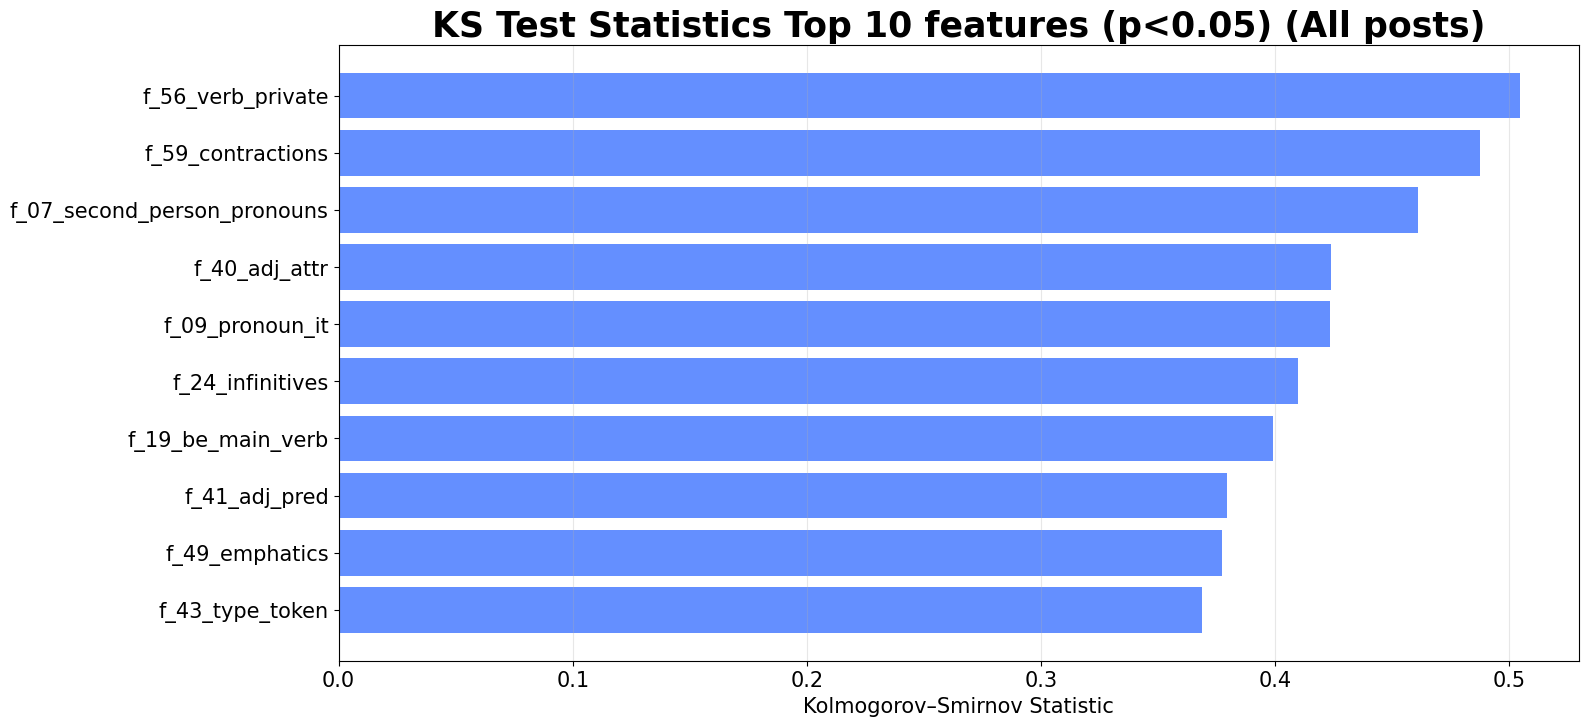

In [ ]:
fig = plt.figure(figsize=(16, 8))

top_ks = ks_importance.head(TOP_N)
colors = ['#648FFF' if p < 0.05 else 'red' for p in top_ks['p_value']]
plt.barh(range(len(top_ks)), top_ks['importance'], color=colors)
plt.yticks(range(len(top_ks)), top_ks['feature'], fontsize=15)
plt.gca().invert_yaxis()
plt.xlabel('Kolmogorov–Smirnov Statistic', fontsize=15)
plt.xticks(fontsize=15)
plt.title('KS Test Statistics Top 10 features (p<0.05) (All posts)', fontweight='bold', fontsize=25)
plt.grid(axis='x', alpha=0.3)
plt.show()

# KL Divergence **Test**

In [ ]:
from scipy.stats import entropy
from scipy.stats import ks_2samp

N_BINS = 50  # Histogram bins for discretization
EPSILON = 1e-10  # Small value to avoid log(0)

def create_probability_distribution(data, feature, bins, epsilon=EPSILON):
    """
    Convert feature values to probability distribution using histogram

    Args:
        data: Series of feature values
        feature: Feature name (for range calculation)
        bins: Bin edges for histogram

    Returns:
        Normalized probability array (sums to 1)
    """
    # Create histogram
    counts, _ = np.histogram(data, bins=bins)

    # Normalize to probability distribution
    prob = counts / counts.sum()

    # Add epsilon to avoid zero probabilities (causes inf in KL divergence)
    prob = prob + epsilon
    prob = prob / prob.sum()  # Re-normalize after adding epsilon

    return prob


def calculate_kl_divergence(ai_df, human_df , n_bins=N_BINS):
    """
    Calculate KL divergence for each Biber feature

    KL(P || Q) = sum(P(x) * log(P(x) / Q(x)))
    where P = AI distribution, Q = human distribution
    """
    print("\nCalculating KL divergences for Biber features...")

    # Get feature columns (exclude doc_id)
    feature_cols = [col for col in human_df.columns if col != 'doc_id']

    results = []

    for feature in feature_cols:
        # Get data for this feature
        human_values = human_df[feature].dropna()
        ai_values = ai_df[feature].dropna()

        # Determine bin edges using combined range
        combined_values = pd.concat([human_values, ai_values])
        min_val = combined_values.min()
        max_val = combined_values.max()

        # Create uniform bin edges
        bins = np.linspace(min_val, max_val, n_bins + 1)

        # Create probability distributions
        human_prob = create_probability_distribution(human_values, feature, bins)
        ai_prob = create_probability_distribution(ai_values, feature, bins)

        # Calculate KL divergence using scipy
        kl_div = entropy(ai_prob, human_prob)

        results.append({
            'feature': feature,
            'kl_divergence': kl_div
        })

        # print(f"  {feature}: {kl_div:.6f}")

    return pd.DataFrame(results)

In [ ]:
ai_kl_test_df = ai_df.sample(frac=0.8, random_state=42)[:15000]
human_kl_test_df = human_df.sample(frac=0.8, random_state=42)[:15000]

In [ ]:
kl_df = calculate_kl_divergence(ai_kl_test_df, human_kl_test_df)

# Sort by KL divergence (descending)
kl_df = kl_df.sort_values('kl_divergence', ascending=False)




Calculating KL divergences for Biber features...


In [ ]:
kl_df.head()

,feature,kl_divergence
58,f_59_contractions,1.946686
55,f_56_verb_private,1.414563
23,f_24_infinitives,1.357141
42,f_43_type_token,1.323203
6,f_07_second_person_pronouns,1.278845


# KS Test

In [ ]:
def calculate_ks_tests(ai_df, human_df):
    """Perform KS test for each Biber feature"""

    # Get feature columns (exclude doc_id)
    feature_cols = [col for col in human_df.columns if col != 'doc_id']

    results = []

    for feature in feature_cols:
        # Get data for this feature
        human_values = human_df[feature].dropna()
        ai_values = ai_df[feature].dropna()

        # Perform two-sample KS test
        statistic, p_value = ks_2samp(human_values, ai_values)

        results.append({
            'feature': feature,
            'ks_statistic': statistic,
            'p_value': p_value,
            'significant': p_value < 0.05
        })

        # sig_marker = "***" if p_value < 0.001 else "**" if p_value < 0.01 else "*" if p_value < 0.05 else ""
        # print(f"  {feature}: KS={statistic:.4f}, p={p_value:.6f} {sig_marker}")

    return pd.DataFrame(results)

In [ ]:
ks_df = calculate_ks_tests(ai_kl_test_df, human_kl_test_df)

# Sort by KL divergence (descending)
ks_df = ks_df.sort_values('ks_statistic', ascending=False)

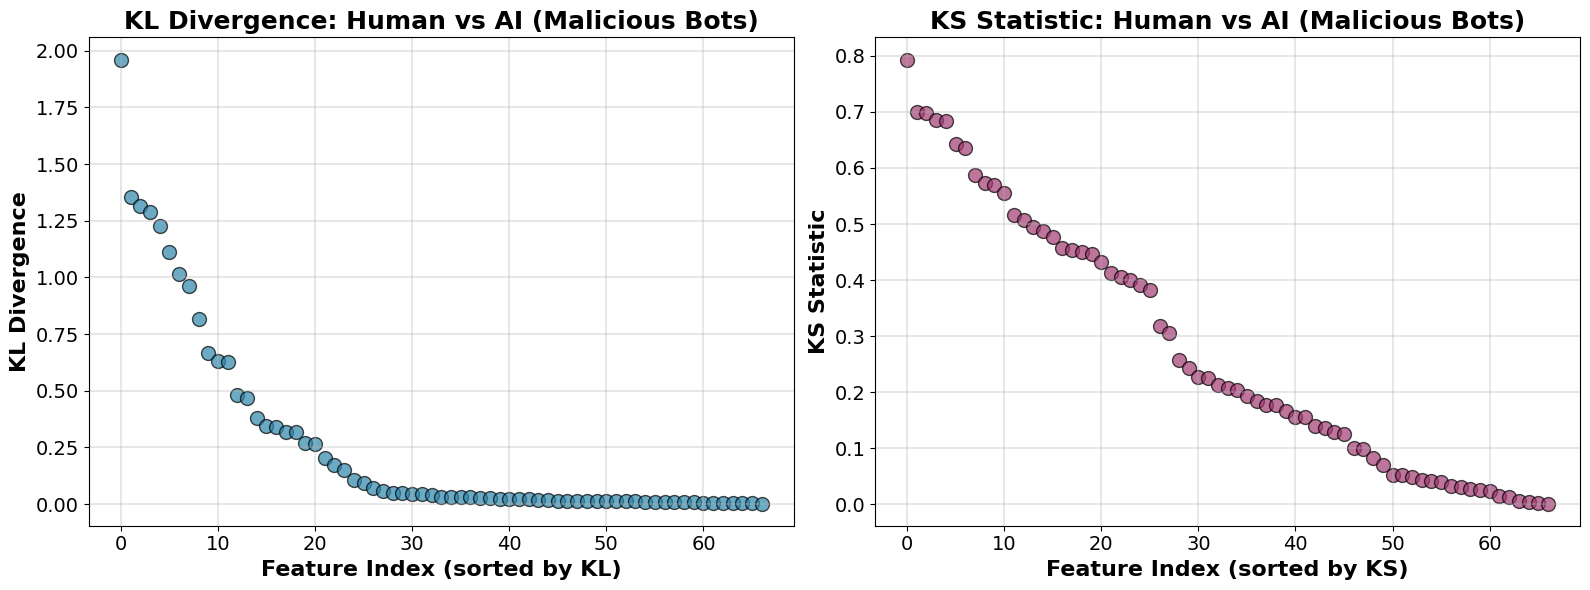

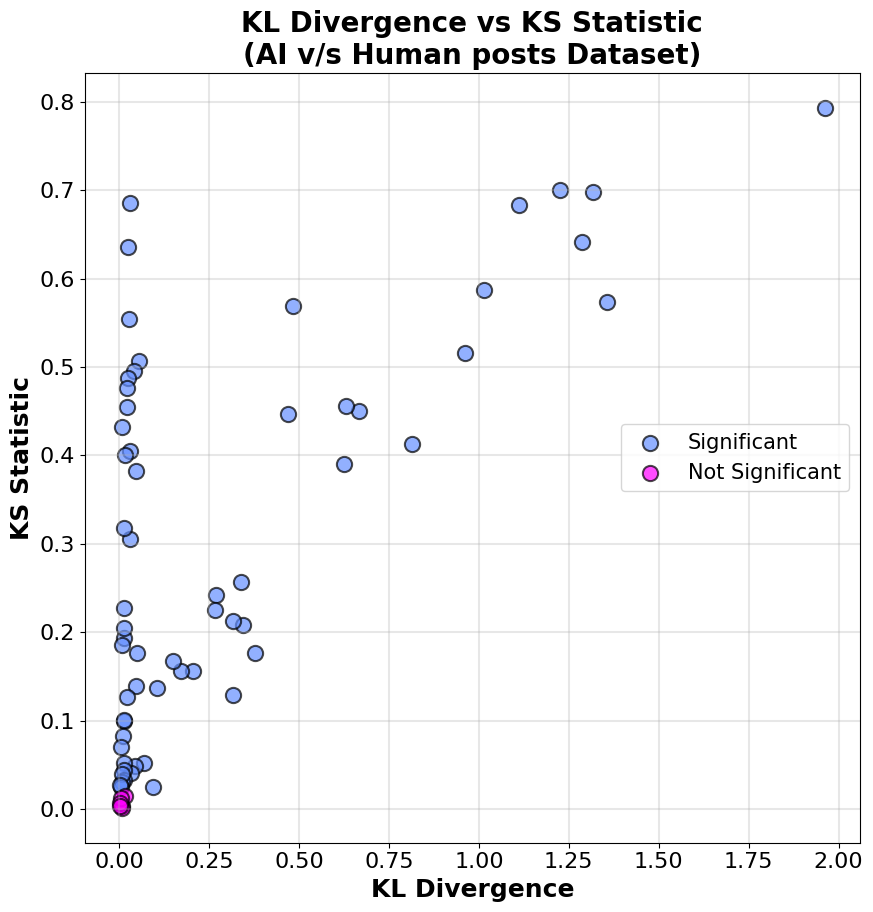


Visualization complete!


In [ ]:
# Merge on feature name
merged = pd.merge(kl_df, ks_df, on='feature', suffixes=('_kl', '_ks'))

# Create figure with 2 subplots
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: KL Divergence scatter
ax1 = axes[0]
ax1.scatter(range(len(kl_df)), kl_df['kl_divergence'],
            s=100, alpha=0.7, c='#2E86AB', edgecolors='black', linewidth=1)
ax1.set_xlabel('Feature Index (sorted by KL)', fontsize=16, fontweight='bold')
ax1.set_ylabel('KL Divergence', fontsize=16, fontweight='bold')
ax1.set_title('KL Divergence: Human vs AI (Malicious Bots)', fontsize=18, fontweight='bold')
ax1.grid(True, alpha=0.3, linewidth=1.5)
ax1.tick_params(labelsize=14)

# Plot 2: KS Statistic scatter
ax2 = axes[1]
ks_sorted = ks_df.sort_values('ks_statistic', ascending=False)
ax2.scatter(range(len(ks_sorted)), ks_sorted['ks_statistic'],
            s=100, alpha=0.7, c='#A23B72', edgecolors='black', linewidth=1)
ax2.set_xlabel('Feature Index (sorted by KS)', fontsize=16, fontweight='bold')
ax2.set_ylabel('KS Statistic', fontsize=16, fontweight='bold')
ax2.set_title('KS Statistic: Human vs AI (Malicious Bots)', fontsize=18, fontweight='bold')
ax2.grid(True, alpha=0.3, linewidth=1.5)
ax2.tick_params(labelsize=14)

plt.tight_layout()
# output_path = OUTPUT_DIR / "kl_ks_scatter_comparison.png"
# plt.savefig(output_path, dpi=300, bbox_inches='tight', facecolor='white')
# print(f"Saved: {output_path}")

# Plot 3: Direct comparison scatter (KL vs KS)

fig2, ax = plt.subplots(figsize=(10, 10))
colors = ['pink' if p < 0.05 else '#648FFF' for p in merged['p_value']]
significant = merged[merged['p_value'] < 0.05]
not_sig = merged[merged['p_value'] >= 0.05]


ax.scatter(significant['kl_divergence'], significant['ks_statistic'],
           s=120, alpha=0.7, c='#648FFF', label='Significant', edgecolors='black', linewidth=1.5)
ax.scatter(not_sig['kl_divergence'], not_sig['ks_statistic'],
           s=120, alpha=0.7, c='magenta', label='Not Significant', edgecolors='black', linewidth=1.5)
ax.set_xlabel('KL Divergence', fontsize=18, fontweight='bold')
ax.set_ylabel('KS Statistic', fontsize=18, fontweight='bold')
ax.set_title('KL Divergence vs KS Statistic\n(AI v/s Human posts Dataset)',
             fontsize=20, fontweight='bold')
ax.grid(True, alpha=0.3, linewidth=1.5)
ax.tick_params(labelsize=16)

# output_path2 = OUTPUT_DIR / "kl_vs_ks_direct_comparison.png"
# plt.savefig(output_path2, dpi=300, bbox_inches='tight', facecolor='white')
# print(f"Saved: {output_path2}")
plt.legend(loc='center right', fontsize=15)
plt.show()
print("\nVisualization complete!")

In [ ]:
feat_disparity = merged[(merged["kl_divergence"] < 0.25) & (merged["ks_statistic"] > 0.5)]


,feature,kl_divergence,ks_statistic,p_value,significant
27,f_13_wh_question,0.055300,0.506323,0.0,True
35,f_19_be_main_verb,0.030670,0.685777,0.0,True
37,f_16_other_nouns,0.027225,0.554465,0.0,True
38,f_40_adj_attr,0.025163,0.636311,0.0,True


In [78]:
def visualize_feature_importance(X, y, top_n=20):
    print("Computing Random Forest importance...")
    rf = RandomForestClassifier(n_estimators=20, random_state=42, max_depth=20)
    rf.fit(X, y)
    rf_importance = pd.DataFrame({
        'feature': X.columns,
        'importance': rf.feature_importances_
    }).sort_values('importance', ascending=False)

    print("Computing Gradient Boosting importance...")
    gb = GradientBoostingClassifier(n_estimators=70, random_state=42, max_depth=7)
    gb.fit(X, y)
    gb_importance = pd.DataFrame({
        'feature': X.columns,
        'importance': gb.feature_importances_
    }).sort_values('importance', ascending=False)

    print("Computing Logistic Regression coefficients...")
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    lr = LogisticRegression(max_iter=1000, random_state=42)
    lr.fit(X_scaled, y)
    lr_importance = pd.DataFrame({
        'feature': X.columns,
        'importance': np.abs(lr.coef_[0])
    }).sort_values('importance', ascending=False)

    print("Computing KS statistics...")
    ks_results = []
    for col in X.columns:
        class_0 = X[y == 0][col].dropna()
        class_1 = X[y == 1][col].dropna()
        stat, p_val = ks_2samp(class_0, class_1)
        ks_results.append({'feature': col, 'importance': stat, 'p_value': p_val})
    ks_importance = pd.DataFrame(ks_results).sort_values('importance', ascending=False)

    return rf_importance, gb_importance, lr_importance, ks_importance

In [81]:
rf_importance, gb_importance, lr_importance, ks_importance = \
visualize_feature_importance(X_posts, y_posts, top_n=10)

Computing Random Forest importance...
Computing Gradient Boosting importance...
Computing Logistic Regression coefficients...
Computing KS statistics...


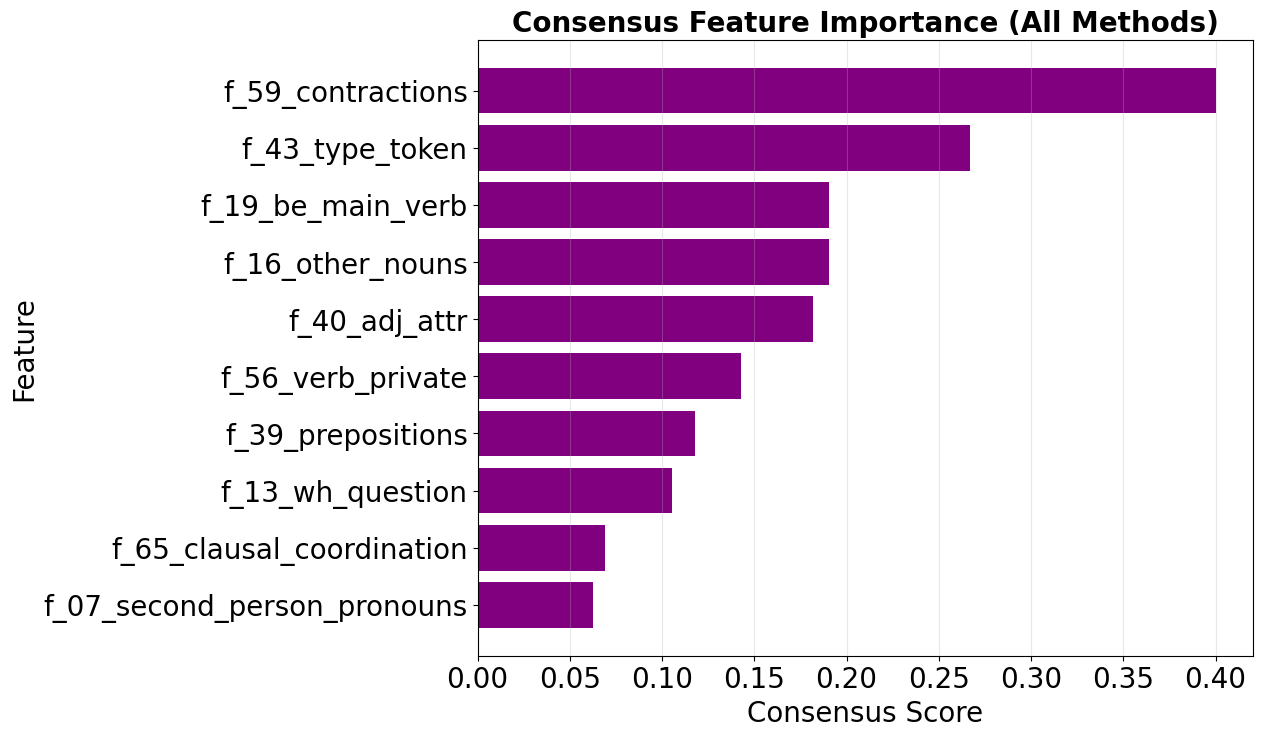

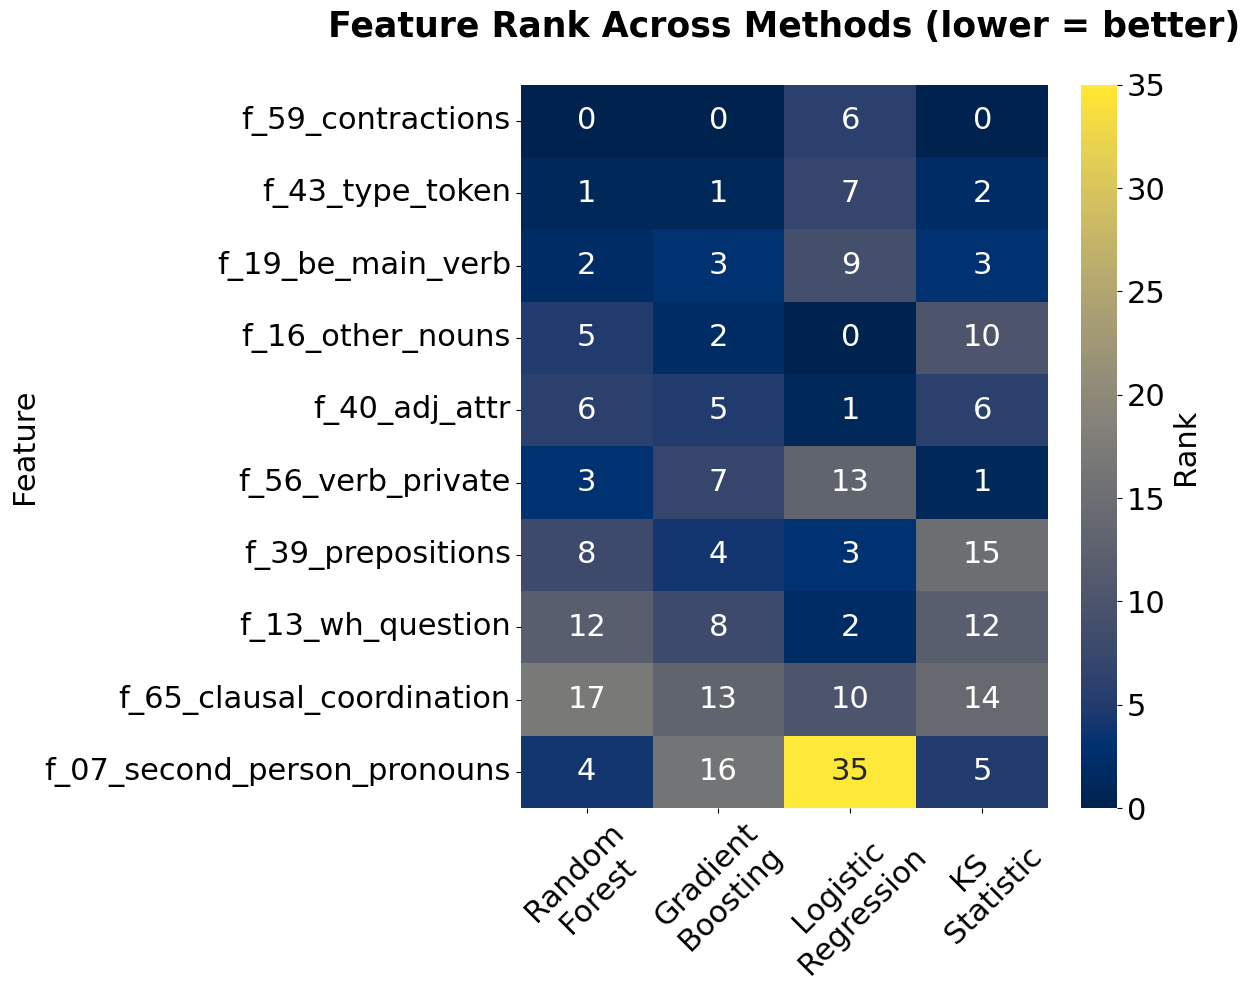

In [96]:
top_n=10
fig = plt.figure(figsize=(10, 8))

# ax1 = plt.subplot(2, 3, 1)
# top_rf = rf_importance.head(top_n)
# ax1.barh(range(len(top_rf)), top_rf['importance'])
# ax1.set_yticks(range(len(top_rf)))
# ax1.set_yticklabels(top_rf['feature'])
# ax1.invert_yaxis()
# ax1.set_xlabel('Importance')
# ax1.set_title('Random Forest Feature Importance')
# ax1.grid(axis='x', alpha=0.3)

# ax2 = plt.subplot(2, 3, 2)
# top_gb = gb_importance.head(top_n)
# ax2.barh(range(len(top_gb)), top_gb['importance'], color='coral')
# ax2.set_yticks(range(len(top_gb)))
# ax2.set_yticklabels(top_gb['feature'])
# ax2.invert_yaxis()
# ax2.set_xlabel('Importance')
# ax2.set_title('Gradient Boosting Feature Importance')
# ax2.grid(axis='x', alpha=0.3)

# ax3 = plt.subplot(2, 3, 3)
# top_lr = lr_importance.head(top_n)
# ax3.barh(range(len(top_lr)), top_lr['importance'], color='green')
# ax3.set_yticks(range(len(top_lr)))
# ax3.set_yticklabels(top_lr['feature'])
# ax3.invert_yaxis()
# ax3.set_xlabel('|Coefficient|')
# ax3.set_title('Logistic Regression (Absolute Coefficients)')
# ax3.grid(axis='x', alpha=0.3)

# ax4 = plt.subplot(2, 3, 4)
# top_ks = ks_importance.head(top_n)
# colors = ['red' if p < 0.05 else 'lightblue' for p in top_ks['p_value']]
# ax4.barh(range(len(top_ks)), top_ks['importance'], color=colors)
# ax4.set_yticks(range(len(top_ks)))
# ax4.set_yticklabels(top_ks['feature'])
# ax4.invert_yaxis()
# ax4.set_xlabel('KS Statistic')
# ax4.set_title('KS Test Statistics (red = p<0.05)')
# ax4.grid(axis='x', alpha=0.3)

# Plot 5: Consensus Ranking (average rank across methods)

ax5 = plt.subplot(1, 1, 1)

# Create rank for each method
rf_importance['rf_rank'] = range(len(rf_importance))
gb_importance['gb_rank'] = range(len(gb_importance))
lr_importance['lr_rank'] = range(len(lr_importance))
ks_importance['ks_rank'] = range(len(ks_importance))

# Merge all rankings
consensus = rf_importance[['feature', 'rf_rank']].copy()
consensus = consensus.merge(gb_importance[['feature', 'gb_rank']], on='feature')
consensus = consensus.merge(lr_importance[['feature', 'lr_rank']], on='feature')
consensus = consensus.merge(ks_importance[['feature', 'ks_rank']], on='feature')

# Average rank
consensus['avg_rank'] = consensus[['rf_rank', 'gb_rank', 'lr_rank', 'ks_rank']].mean(axis=1)
consensus = consensus.sort_values('avg_rank')

top_consensus = consensus.head(top_n)
ax5.barh(range(len(top_consensus)), 1 / (top_consensus['avg_rank'] + 1), color='purple')
ax5.set_yticks(range(len(top_consensus)))
ax5.set_yticklabels(top_consensus['feature'], fontsize=20)
ax5.set_ylabel('Feature', fontsize=20)
ax5.invert_yaxis()
ax5.set_xlabel('Consensus Score', fontsize=20)
ax5.set_xticklabels(ax5.get_xticklabels(), fontsize=20)
ax5.set_title('Consensus Feature Importance (All Methods)', fontsize=20, fontweight='bold')
ax5.grid(axis='x', alpha=0.3)
plt.show()

fig = plt.figure(figsize=(12, 10))
# Plot 6: Heatmap of Rankings
ax6 = plt.subplot(1, 1, 1)

# Get top features from consensus
top_features = top_consensus['feature'].head(15).tolist()

# Create matrix of ranks for these features
rank_matrix = []
for feat in top_features:
    ranks = [
        rf_importance[rf_importance['feature'] == feat]['rf_rank'].values[0],
        gb_importance[gb_importance['feature'] == feat]['gb_rank'].values[0],
        lr_importance[lr_importance['feature'] == feat]['lr_rank'].values[0],
        ks_importance[ks_importance['feature'] == feat]['ks_rank'].values[0]
    ]
    rank_matrix.append(ranks)

rank_df = pd.DataFrame(rank_matrix,
                        columns=['Random\nForest', 'Gradient\nBoosting', 'Logistic\nRegression', 'KS\nStatistic'],
                        index=top_features)

sns.heatmap(rank_df, annot=True, fmt='.0f', cmap='cividis',
            ax=ax6, cbar_kws={'label': 'Rank'}, annot_kws={"size": 22})

# 2. Set the font size of the color bar label using its 'set_size' method
cbar = ax6.collections[0].colorbar
cbar.ax.yaxis.label.set_size(22)
cbar.ax.tick_params(labelsize=22)

ax6.set_title('Feature Rank Across Methods (lower = better)\n', fontsize=25, fontweight='bold')
ax6.set_yticklabels(ax6.get_yticklabels(), fontsize=22)
ax6.set_ylabel('Feature', fontsize=22)
ax6.set_xticklabels(ax6.get_xticklabels(), fontsize=22, rotation=45)
plt.tight_layout()
plt.show()

consensus = consensus.sort_values('avg_rank')
